# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_063  P02652;V9GYM3     21.709
Sample_157  P0C0L4            18.991
Sample_151  P47972            18.703
Sample_078  Q9GZT8;Q9GZT8-2   14.466
Sample_130  M0R009            22.028
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                        
Sample_103  F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3   12.770
Sample_170  Q9NS84                                    9.040
Sample_038  P06702                                   10.260
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.111
            A0A075B6Q5                 11.954
            A0A075B6R2                 11.571
            A0A075B6S5                 13.645
            A0A087WSY4                 11.803
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.774
            Q9UI40;Q9UI40-2            12.435
            Q9UIW2                     12.348
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.479
            Q9UP79                     12.446
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.024,15.050,16.842,19.863,13.509,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.242,19.067,...,15.528,15.576,11.180,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.202,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,11.596,17.705,17.039,12.845,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,13.505,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.261,15.345,17.084,18.708,14.249,19.433,9.415,9.582
Sample_207,15.739,16.877,15.469,16.898,14.809,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.111,...,16.012,15.178,13.030,15.050,16.842,19.863,12.503,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.407,19.067,16.188,...,15.528,15.576,14.101,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.177,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.175,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.912,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.761,15.345,17.084,18.708,14.249,19.433,12.850,13.678
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 364.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.26it/s]

100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.70it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.78it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.83it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.14it/s]

100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

100%|██████████| 5/5 [00:01<00:00,  4.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.55it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.36it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.23it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.06it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.11it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.03it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.83it/s]

100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.34it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.47it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.90it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.66it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.47it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.36it/s]

100%|██████████| 8/8 [00:02<00:00,  3.37it/s]

100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.71it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.32it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.65it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.45it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.49it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.57it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.68it/s]

100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.13it/s]

 30%|███       | 3/10 [00:00<00:02,  3.40it/s]

 40%|████      | 4/10 [00:01<00:02,  2.92it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.99it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.19it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.25it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.25it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.32it/s]

100%|██████████| 10/10 [00:03<00:00,  3.34it/s]

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.86it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.78it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.86it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.61it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.62it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.63it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.62it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.33it/s]

 91%|█████████ | 10/11 [00:02<00:00,  2.82it/s]

100%|██████████| 11/11 [00:03<00:00,  2.31it/s]

100%|██████████| 11/11 [00:03<00:00,  3.12it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.94it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.48it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.13it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.62it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.37it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.27it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.41it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.41it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.18it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.12it/s]

100%|██████████| 12/12 [00:04<00:00,  2.08it/s]

100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.20it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.23it/s]

 31%|███       | 4/13 [00:01<00:03,  2.90it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.89it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.92it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.86it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.82it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.77it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.68it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.42it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.34it/s]

100%|██████████| 13/13 [00:04<00:00,  2.25it/s]

100%|██████████| 13/13 [00:04<00:00,  2.63it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.84it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.93it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.17it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.92it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.08it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.01it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.93it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.04it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.83it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.48it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.43it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.45it/s]

100%|██████████| 14/14 [00:04<00:00,  2.49it/s]

100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.45it/s]

 20%|██        | 3/15 [00:00<00:02,  4.39it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.48it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.21it/s]

 40%|████      | 6/15 [00:01<00:02,  3.09it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.20it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.69it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.49it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.36it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.36it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.47it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.57it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.53it/s]

100%|██████████| 15/15 [00:05<00:00,  2.23it/s]

100%|██████████| 15/15 [00:05<00:00,  2.68it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.089 0.040          0.685 0.387       0.103   
2             0.005 0.004      0.073 0.031          0.711 0.083       0.608   
3             0.006 0.004      0.068 0.025          0.698 0.095       0.600   
4             0.005 0.004      0.073 0.028          0.706 0.085       0.667   
5             0.006 0.005      0.082 0.037          0.707 0.082       0.678   
6             0.005 0.003      0.056 0.017          0.707 0.087       0.678   
7             0.006 0.005      0.076 0.029          0.799 0.083       0.743   
8             0.007 0.007      0.078 0.034          0.806 0.080       0.822   
9             0.005 0.003      0.057 0.017          0.807 0.082       0.818   
10            0.007 0.006      0.078 0.029          0.796 0.079       0.817   
11            0.007 0.006      0.075 0.035          0.795 0.077       0.838   
12            0.006 0.005      0.062 0.021          0.793 0.074       0.827   
13            0.005 0.005      0.064 0.026          0.794 0.075       0.824   
14            0.006 0.005      0.077 0.031          0.803 0.090       0.812   
15            0.008 0.008      0.077 0.032          0.799 0.091       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.171 0.130                  0.542 0.040        0.849   
2          0.102   0.649 0.074                  0.712 0.054        0.782   
3          0.108   0.638 0.079                  0.702 0.058        0.775   
4          0.116   0.678 0.076                  0.729 0.055        0.782   
5          0.107   0.687 0.073                  0.735 0.057        0.801   
6          0.106   0.687 0.074                  0.734 0.058        0.799   
7          0.100   0.766 0.075                  0.802 0.059        0.854   
8          0.094   0.809 0.063                  0.836 0.054        0.906   
9          0.097   0.808 0.063                  0.836 0.054        0.905   
10         0.097   0.803 0.065                  0.830 0.057        0.902   
11         0.093   0.812 0.060                  0.838 0.053        0.906   
12         0.093   0.805 0.059                  0.833 0.052        0.906   
13         0.098   0.804 0.057                  0.832 0.050        0.905   
14         0.088   0.802 0.061                  0.830 0.053        0.910   
15         0.090   0.799 0.061                  0.827 0.053        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.808 0.083        210.000 0.000  
2          0.062                  0.752 0.078        210.000 0.000  
3          0.062                  0.731 0.081        210.000 0.000  
4          0.062                  0.727 0.089        210.000 0.000  
5          0.059                  0.755 0.081        210.000 0.000  
6          0.060                  0.754 0.081        210.000 0.000  
7          0.060                  0.819 0.082        210.000 0.000  
8          0.044                  0.883 0.055        210.000 0.000  
9          0.044                  0.882 0.056        210.000 0.000  
10         0.045                  0.880 0.055        210.000 0.000  
11         0.045                  0.893 0.046        210.000 0.000  
12         0.047                  0.894 0.049        210.000 0.000  
13         0.047                  0.892 0.049        210.000 0.000  
14         0.047                  0.901 0.048        210.000 0.000  
15         0.047                  0.898 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 280.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.91it/s]

100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.60it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.14it/s]

100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.93it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.40it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.28it/s]

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.88it/s]

100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.83it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.05it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.31it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.60it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.21it/s]

100%|██████████| 7/7 [00:02<00:00,  2.08it/s]

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.23it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.65it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.54it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.04it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.96it/s]

100%|██████████| 8/8 [00:03<00:00,  1.96it/s]

100%|██████████| 8/8 [00:03<00:00,  2.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.97it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.18it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.62it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.91it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.45it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.16it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.08it/s]

100%|██████████| 9/9 [00:03<00:00,  2.06it/s]

100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.80it/s]

 30%|███       | 3/10 [00:00<00:01,  4.16it/s]

 40%|████      | 4/10 [00:01<00:01,  3.44it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.17it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.39it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.15it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.99it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.03it/s]

100%|██████████| 10/10 [00:04<00:00,  1.98it/s]

100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.58it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.77it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.17it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.51it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.13it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.17it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.96it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.09it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.14it/s]

100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.33it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.69it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.33it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.71it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.43it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.07it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.00it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.10it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.08it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.21it/s]

100%|██████████| 12/12 [00:05<00:00,  2.17it/s]

100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.52it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.81it/s]

 31%|███       | 4/13 [00:01<00:03,  2.83it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.73it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.25it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.04it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.97it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.92it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.05it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.08it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.23it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

100%|██████████| 13/13 [00:05<00:00,  2.32it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.52it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.58it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.12it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.94it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.35it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.10it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.99it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.09it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.15it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.28it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.31it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.30it/s]

100%|██████████| 14/14 [00:05<00:00,  2.17it/s]

100%|██████████| 14/14 [00:05<00:00,  2.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  3.25it/s]

 20%|██        | 3/15 [00:01<00:04,  2.81it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.82it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.78it/s]

 40%|████      | 6/15 [00:02<00:03,  2.82it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.24it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.98it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.94it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.95it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.04it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.88it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.71it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.74it/s]

100%|██████████| 15/15 [00:07<00:00,  1.74it/s]

100%|██████████| 15/15 [00:07<00:00,  2.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.065 0.026          0.903 0.152       0.172   
2             0.006 0.005      0.069 0.027          0.782 0.088       0.720   
3             0.006 0.005      0.085 0.036          0.802 0.089       0.742   
4             0.004 0.003      0.059 0.023          0.769 0.087       0.717   
5             0.005 0.005      0.051 0.021          0.761 0.091       0.702   
6             0.005 0.003      0.079 0.035          0.769 0.094       0.713   
7             0.007 0.006      0.073 0.028          0.801 0.089       0.809   
8             0.004 0.001      0.058 0.022          0.800 0.092       0.788   
9             0.005 0.004      0.056 0.018          0.799 0.092       0.792   
10            0.005 0.004      0.058 0.020          0.795 0.086       0.781   
11            0.005 0.003      0.057 0.017          0.837 0.082       0.810   
12            0.004 0.002      0.053 0.014          0.808 0.087       0.811   
13            0.005 0.005      0.057 0.020          0.795 0.081       0.815   
14            0.006 0.005      0.065 0.025          0.801 0.085       0.841   
15            0.005 0.002      0.061 0.022          0.814 0.079       0.853   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.093   0.278 0.127                  0.578 0.045        0.852   
2          0.107   0.744 0.076                  0.785 0.060        0.866   
3          0.104   0.766 0.075                  0.802 0.061        0.865   
4          0.103   0.736 0.071                  0.777 0.058        0.863   
5          0.101   0.724 0.067                  0.767 0.053        0.869   
6          0.102   0.734 0.073                  0.775 0.058        0.868   
7          0.108   0.800 0.077                  0.829 0.065        0.892   
8          0.108   0.788 0.076                  0.819 0.063        0.893   
9          0.103   0.790 0.075                  0.821 0.063        0.897   
10         0.102   0.782 0.070                  0.814 0.058        0.895   
11         0.098   0.819 0.069                  0.845 0.057        0.915   
12         0.101   0.805 0.071                  0.833 0.061        0.917   
13         0.105   0.800 0.070                  0.829 0.060        0.916   
14         0.084   0.817 0.063                  0.842 0.055        0.919   
15         0.085   0.829 0.059                  0.853 0.052        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.088        210.000 0.000  
2          0.056                  0.825 0.080        210.000 0.000  
3          0.059                  0.822 0.084        210.000 0.000  
4          0.056                  0.818 0.081        210.000 0.000  
5          0.054                  0.824 0.079        210.000 0.000  
6          0.055                  0.826 0.079        210.000 0.000  
7          0.049                  0.866 0.061        210.000 0.000  
8          0.049                  0.864 0.065        210.000 0.000  
9          0.046                  0.867 0.059        210.000 0.000  
10         0.047                  0.867 0.059        210.000 0.000  
11         0.043                  0.904 0.048        210.000 0.000  
12         0.041                  0.904 0.048        210.000 0.000  
13         0.043                  0.903 0.048        210.000 0.000  
14         0.042                  0.909 0.047        210.000 0.000  
15         0.040                  0.910 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 976.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.06it/s]

100%|██████████| 3/3 [00:00<00:00, 20.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.40it/s]

100%|██████████| 4/4 [00:00<00:00, 11.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.21it/s]

100%|██████████| 5/5 [00:00<00:00, 16.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.70it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.81it/s]

100%|██████████| 6/6 [00:00<00:00, 14.10it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.74it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.56it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.26it/s]

100%|██████████| 7/7 [00:00<00:00, 11.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.53it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.35it/s]

100%|██████████| 8/8 [00:00<00:00, 15.32it/s]

100%|██████████| 8/8 [00:00<00:00, 15.95it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.33it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.38it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.44it/s]

100%|██████████| 9/9 [00:00<00:00, 13.47it/s]

100%|██████████| 9/9 [00:00<00:00, 13.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.37it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.53it/s]

 80%|████████  | 8/10 [00:00<00:00, 14.21it/s]

100%|██████████| 10/10 [00:00<00:00, 14.01it/s]

100%|██████████| 10/10 [00:00<00:00, 14.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.57it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.10it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.35it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.93it/s]

100%|██████████| 11/11 [00:00<00:00, 14.31it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 14.81it/s]

 33%|███▎      | 4/12 [00:00<00:00, 13.69it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.75it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 12.30it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.85it/s]

100%|██████████| 12/12 [00:01<00:00, 10.36it/s]

100%|██████████| 12/12 [00:01<00:00, 11.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.75it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.51it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.24it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.49it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 14.03it/s]

100%|██████████| 13/13 [00:00<00:00, 13.76it/s]

100%|██████████| 13/13 [00:00<00:00, 14.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 14.45it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.85it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.52it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.01it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.75it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.60it/s]

100%|██████████| 14/14 [00:01<00:00, 11.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.92it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.48it/s]

 40%|████      | 6/15 [00:00<00:01,  8.94it/s]

 47%|████▋     | 7/15 [00:00<00:00,  9.02it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.40it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.73it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.71it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.87it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.77it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.96it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.98it/s]

100%|██████████| 15/15 [00:01<00:00,  8.37it/s]

100%|██████████| 15/15 [00:01<00:00,  8.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.073 0.025          0.000 0.000       0.000   
2             0.007 0.007      0.075 0.026          0.083 0.261       0.008   
3             0.006 0.005      0.078 0.025          0.359 0.359       0.071   
4             0.005 0.004      0.058 0.022          0.599 0.120       0.398   
5             0.004 0.002      0.064 0.022          0.594 0.116       0.405   
6             0.004 0.001      0.047 0.007          0.575 0.126       0.393   
7             0.005 0.003      0.057 0.018          0.586 0.097       0.419   
8             0.005 0.003      0.059 0.023          0.563 0.103       0.465   
9             0.005 0.003      0.049 0.010          0.565 0.086       0.473   
10            0.008 0.006      0.101 0.028          0.609 0.093       0.552   
11            0.006 0.005      0.078 0.038          0.650 0.106       0.575   
12            0.007 0.006      0.068 0.026          0.650 0.108       0.578   
13            0.007 0.006      0.080 0.030          0.649 0.106       0.578   
14            0.005 0.003      0.053 0.013          0.640 0.108       0.566   
15            0.006 0.005      0.064 0.026          0.635 0.112       0.562   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.722   
2          0.026   0.015 0.047                  0.502 0.013        0.668   
3          0.082   0.112 0.119                  0.513 0.031        0.666   
4          0.123   0.470 0.110                  0.602 0.065        0.669   
5          0.128   0.474 0.111                  0.602 0.067        0.660   
6          0.132   0.458 0.122                  0.592 0.072        0.642   
7          0.130   0.477 0.104                  0.600 0.058        0.642   
8          0.106   0.504 0.089                  0.599 0.066        0.666   
9          0.107   0.509 0.084                  0.602 0.060        0.667   
10         0.117   0.572 0.087                  0.644 0.068        0.694   
11         0.129   0.603 0.097                  0.672 0.072        0.742   
12         0.126   0.604 0.096                  0.673 0.073        0.738   
13         0.135   0.604 0.101                  0.673 0.076        0.730   
14         0.131   0.594 0.100                  0.665 0.078        0.726   
15         0.129   0.588 0.096                  0.660 0.074        0.719   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.075                  0.672 0.091        210.000 0.000  
2          0.077                  0.629 0.094        210.000 0.000  
3          0.092                  0.610 0.106        210.000 0.000  
4          0.078                  0.584 0.076        210.000 0.000  
5          0.075                  0.576 0.075        210.000 0.000  
6          0.078                  0.560 0.075        210.000 0.000  
7          0.077                  0.569 0.074        210.000 0.000  
8          0.073                  0.617 0.082        210.000 0.000  
9          0.071                  0.626 0.074        210.000 0.000  
10         0.074                  0.654 0.083        210.000 0.000  
11         0.076                  0.694 0.089        210.000 0.000  
12         0.079                  0.690 0.092        210.000 0.000  
13         0.080                  0.679 0.092        210.000 0.000  
14         0.081                  0.677 0.090        210.000 0.000  
15         0.081                  0.670 0.089 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,7,10
score_time,1,3,10
test_precision,9,1,12
test_recall,11,15,13
test_f1,11,15,12
test_balanced_accuracy,11,15,13
test_roc_auc,14,15,11
test_average_precision,14,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.71it/s]

 20%|██        | 3/15 [00:00<00:03,  3.48it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.03it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.74it/s]

 40%|████      | 6/15 [00:02<00:03,  2.39it/s]

 47%|████▋     | 7/15 [00:02<00:04,  1.95it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.79it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.65it/s]

 67%|██████▋   | 10/15 [00:04<00:03,  1.62it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.74it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.94it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.01it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.04it/s]

100%|██████████| 15/15 [00:07<00:00,  1.86it/s]

100%|██████████| 15/15 [00:07<00:00,  2.05it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.51it/s]

 36%|███▋      | 4/11 [00:00<00:00, 10.48it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.64it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.21it/s]

 91%|█████████ | 10/11 [00:00<00:00,  9.76it/s]

100%|██████████| 11/11 [00:01<00:00,  9.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.97it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.57it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.15it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.11it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.24it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.75it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.49it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.11it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.06it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.99it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.85it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.88it/s]

100%|██████████| 14/14 [00:06<00:00,  1.86it/s]

100%|██████████| 14/14 [00:06<00:00,  2.27it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


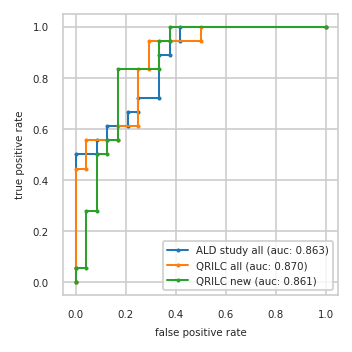

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.500     0.000 0.444     0.042 0.056
3          0.083 0.500     0.042 0.444     0.042 0.278
4          0.083 0.556     0.042 0.556     0.083 0.278
5          0.125 0.556     0.167 0.556     0.083 0.500
6          0.125 0.611     0.167 0.611     0.125 0.500
7          0.208 0.611     0.250 0.611     0.125 0.556
8          0.208 0.667     0.250 0.833     0.167 0.556
9          0.250 0.667     0.292 0.833     0.167 0.833
10         0.250 0.722     0.292 0.944     0.333 0.833
11         0.333 0.722     0.500 0.944     0.333 0.944
12         0.333 0.889     0.500 1.000     0.375 0.944
13         0.375 0.889     1.000 1.000     0.375 1.000
14         0.375 0.944       NaN   NaN     1.000 1.000
15         0.417 0.944       NaN   NaN       NaN   NaN
16         0.417 1.000       NaN   NaN       NaN   NaN
17         1.000 1.000       NaN   NaN       NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P31321
1,F5H265,P60709;P63261,P04430
2,A0A0A0MRJ7;P12259,P10636-2;P10636-6,Q96SM3
3,P61981,A0A0A0MRJ7;P12259,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2
4,P14174,P14174,D6R956;P09936
5,P04075,P61981,H0Y7T8;P49418;P49418-2
6,Q9Y2T3;Q9Y2T3-3,P04075,P10644;P10644-2
7,P00338;P00338-3,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,Q14894
8,C9JF17;P05090,P63104,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


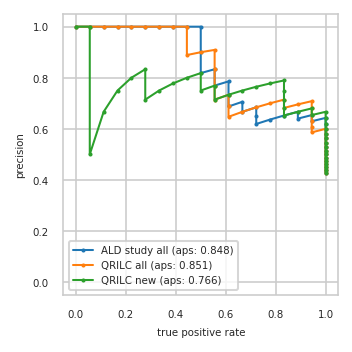

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.562 1.000
11         0.581 1.000     0.581 1.000     0.581 1.000
12         0.600 1.000     0.600 1.000     0.600 1.000
13         0.621 1.000     0.586 0.944     0.621 1.000
14         0.643 1.000     0.607 0.944     0.643 1.000
15         0.630 0.944     0.630 0.944     0.667 1.000
16         0.654 0.944     0.654 0.944     0.654 0.944
17         0.640 0.889     0.680 0.944     0.680 0.944
18         0.667 0.889     0.708 0.944     0.667 0.889
19         0.652 0.833     0.696 0.889     0.652 0.833
20         0.636 0.778     0.682 0.833     0.682 0.833
21         0.619 0.722     0.714 0.833     0.714 0.833
22         0.650 0.722     0.700 0.778     0.750 0.833
23         0.684 0.722     0.684 0.722     0.789 0.833
24         0.667 0.667     0.667 0.667     0.778 0.778
25         0.706 0.667     0.647 0.611     0.765 0.722
26         0.688 0.611     0.688 0.611     0.750 0.667
27         0.733 0.611     0.733 0.611     0.733 0.611
28         0.786 0.611     0.714 0.556     0.714 0.556
29         0.769 0.556     0.769 0.556     0.769 0.556
30         0.833 0.556     0.833 0.556     0.750 0.500
31         0.818 0.500     0.909 0.556     0.818 0.500
32         0.900 0.500     0.900 0.500     0.800 0.444
33         1.000 0.500     0.889 0.444     0.778 0.389
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


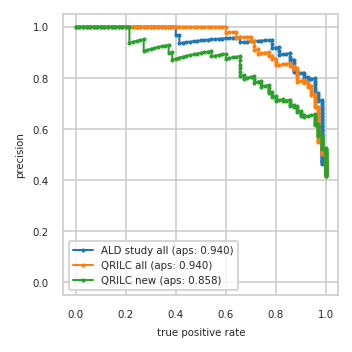

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


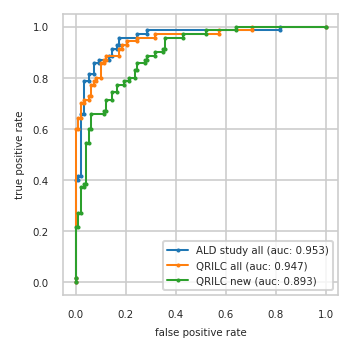

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}